In [20]:
import os
import json
import numpy as np

import torch
import torch.nn as nn
from torch.optim import AdamW
import cv2
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.models import resnet18
import torchvision
from torchvision.transforms import transforms
from torchvision.transforms import ToTensor, Lambda

from glob import glob
import shutil
from sklearn.model_selection import train_test_split
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
label_dir= "./drive/MyDrive/Xouterj"
image_dir = "./drive/MyDrive/Xouterp"
SAVE_DIR="./drive/MyDrive/model_ckpoint"
# VALID_LABELING_DIR = r"C:\Users\dra04\fashion image\K-Fashion 이미지\Validation\라벨링데이터\클래식"
# VALID_IMAGE_DIR = r"C:\Users\dra04\fashion image\K-Fashion 이미지\Validation\원천데이터\클래식"

json_files = []
image_files=[]
# valid_json_files = []

#for train_file, valid_file in zip(os.listdir(TRAIN_LABELING_DIR), os.listdir(VALID_LABELING_DIR)):
for train_file in os.listdir(label_dir):
    json_files.append(os.path.join(label_dir, train_file))
    image_files.append(os.path.splitext(train_file)[0])

    # for valid_file in os.listdir(VALID_LABELING_DIR):    
#     valid_json_files.append(os.path.join(VALID_LABELING_DIR, valid_file))

print("훈련 데이터 개수:", len(json_files), len(image_files))

# print("평가 데이터 개수:", len(valid_json_files))

훈련 데이터 개수: 7861 7861


In [3]:
train_image, test_image, train_json, test_json = train_test_split(image_files, json_files, test_size=0.4, random_state=42, 
shuffle=True)
test_image, val_image, test_json, val_json = train_test_split(test_image, test_json, test_size=0.5, random_state=42, shuffle=True)
print(len(train_image), len(test_image), len(val_image))
print(len(train_json), len(test_json), len(val_json))

4716 1572 1573
4716 1572 1573


In [4]:
clothes_class = ["아우터", "하의", "원피스", "상의"]
clothes_xy = {"outer_xy":None, "pants_xy":None, "onepiece_xy":None, "shirt_xy":None}
clothes_fabric = {"outer_fabric":None, "pants_fabric":None, "onepiece_fabric":None, "shirt_fabric":None}

train_image_dict = {}
valid_image_dict = {}

for file in tqdm(train_json):
    if os.path.splitext(file.split("/")[-1])[0] not in train_image: #이미지 파일 없을 때
        continue
    with open(file, "rb") as f:
        data = json.load(f)
        file_id = data['이미지 정보']['이미지 식별자']
        file_name=str(data['이미지 정보']['이미지 식별자'])+'.jpg'
        for cls, xy, fabric in zip(clothes_class, clothes_xy, clothes_fabric):
            clothes_xy[xy] = data['데이터셋 정보']['데이터셋 상세설명']['렉트좌표'][cls][0].values()
            if not clothes_xy[xy]:
                continue
#             if list(clothes_xy[xy])[2] < 1 or list(clothes_xy[xy])[3] < 1:
#                 print(file)
#                 continue
            try:
                clothes_fabric[fabric] = data['데이터셋 정보']['데이터셋 상세설명']['라벨링'][cls][0]['소재']
            except:
                pass
#                 print(file_name) #소재 없는 파일 
#                 print("--------------------")
        #print(clothes_xy)
        #print(clothes_fabric)

    for xy, fabric in zip(clothes_xy.values(), clothes_fabric.values()):
        if not xy:
            continue
        if list(xy)[2] < 1 or list(xy)[3] < 1:
            continue
        train_image_dict[(file_name, xy)] = fabric

        

for file in tqdm(val_json):
    if os.path.splitext(file.split("/")[-1])[0] not in val_image: #이미지 파일 없을 때
        continue
    with open(file, "rb") as f:
        data = json.load(f)
        file_name = str(data['이미지 정보']['이미지 식별자'])+'.jpg'
        for cls, xy, fabric in zip(clothes_class, clothes_xy, clothes_fabric):
            clothes_xy[xy] = data['데이터셋 정보']['데이터셋 상세설명']['렉트좌표'][cls][0].values()
            if not clothes_xy[xy]:
                continue
            try:
                clothes_fabric[fabric] = data['데이터셋 정보']['데이터셋 상세설명']['라벨링'][cls][0]['소재']
            except:
                pass
        # print(clothes_xy)
        # print(clothes_fabric)

    for xy, fabric in zip(clothes_xy.values(), clothes_fabric.values()):
        if not xy:
            continue
        if list(xy)[2] < 1 or list(xy)[3] < 1:
            continue        
        valid_image_dict[(file_name, xy)] = fabric     
        
train_image_dict
valid_image_dict

100%|██████████| 1573/1573 [00:02<00:00, 668.40it/s]


{('1167401.jpg', dict_values([107.5, 54.5, 554, 825])): ['우븐'],
 ('1077601.jpg', dict_values([182.5, 0.5, 484, 1013])): ['니트'],
 ('342601.jpg', dict_values([202.5, 37.5, 269, 494])): ['니트'],
 ('301701.jpg', dict_values([201.5, 344.5, 453, 443])): ['우븐'],
 ('682601.jpg', dict_values([327.938, 458.115, 162, 236])): ['우븐'],
 ('1146001.jpg', dict_values([325.203, 691.5, 151, 350])): ['데님'],
 ('1146001.jpg', dict_values([301.203, 500.5, 159, 307])): ['우븐'],
 ('27501.jpg', dict_values([160.203, 61.5, 393, 737])): ['우븐'],
 ('393001.jpg', dict_values([259.5, 250.5, 278, 704])): ['데님'],
 ('393001.jpg', dict_values([228.5, 32.5, 325, 233])): ['저지'],
 ('1284901.jpg', dict_values([355.388, 86.4276, 195, 221])): ['니트'],
 ('516501.jpg', dict_values([193.5, 14.5, 355, 817])): ['우븐'],
 ('1085401.jpg', dict_values([273.167, 271.241, 308, 301])): ['울/캐시미어'],
 ('1085401.jpg', dict_values([245.167, 19.4809, 312, 281])): ['실크'],
 ('121001.jpg', dict_values([213.203, 43.5, 426, 617])): ['저지'],
 ('117801.jpg

In [8]:
class ClothDataset(Dataset):
    def __init__(self, train_image_dict, data_dir=r"./drive/MyDrive/Xouterp"): #C:\Users\dra04\fashion image\K-Fashion 이미지\Training\원천데이터
        super().__init__()
        self.data_dir = data_dir
        self.train_image_dict = train_image_dict
        self.image_files = []
        self.dict_label_to_num = {
            "퍼" : 0,
            "니트" : 1,
            "무스탕" : 2,
            "레이스" : 3,
            "스웨이드" : 4,
            "린넨" : 5,
            "앙고라" : 6,
            "메시" : 7,
            "코듀로이" : 8,
            "플리스" : 9,
            "시퀸/글리터" : 10,
            "네오프렌" : 11,
            "데님" : 12,
            "실크" : 13,
            "저지" : 14,
            "스판덱스" : 15,
            "트위드" : 16,
            "자카드" : 17,
            "벨벳" : 18,
            "가죽" : 19,
            "비닐/PVC" : 20,
            "면" : 21,
            "울/캐시미어" : 22,
            "시폰" : 23,
            "합성섬유" : 24,
            "우븐" : 25,
            "패딩" : 26,
            "헤어 니트": 27
        }
        self.setup()

    def setup(self):
        for (file_name, xy), fabric in self.train_image_dict.items():
            if not fabric:
                continue
            self.image_files.append((os.path.join(self.data_dir, file_name), xy, fabric)) #os.path.join(data_dir+이미지명)/좌표/직물을 list에

    def __getitem__(self, idx):
        file_name, xy, fabric = self.image_files[idx]
        fabric=fabric[0]
        x, y, w, h = map(int, xy)
#         for i in [x, y, w, h]:
#             if i < 1:
#                 i = 1
#         x1 = x+int(w/3)
#         y1 = y+int(h/3)
#         h1 = int(h/3)
#         w1 = int(w/3)
        im = Image.open(file_name)
        im = transforms.ToTensor()(im)
        im = torchvision.transforms.functional.crop(im, y, x, h, w)
        im = transforms.Resize((200,200), Image.BILINEAR)(im)

        fabric_label = self.dict_label_to_num[fabric]
        return im, fabric_label
    
    def __len__(self):
        return len(self.image_files)



In [9]:
train_dataset = ClothDataset(train_image_dict)
valid_dataset = ClothDataset(valid_image_dict)
print(len(train_dataset))
print(len(valid_dataset))

6600
2224


In [24]:
import torch.nn.functional as F

class Resnet50(nn.Module): #18
    def __init__(self, num_classes):
        super().__init__()
        self.model = torchvision.models.resnet50(pretrained=True) #50

        self.fc = nn.Linear(1000, num_classes)
        
    def forward(self, x):
        x = self.model(x)
        return self.fc(x)


In [28]:
BATCH_SIZE = 64 #32
EPOCHS =10
LOG_INTERVAL=50 #100
LEARNING_RATE=0.001 #0.001
SAVE_DIR="./results"

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader=DataLoader(train_dataset, batch_size=BATCH_SIZE, drop_last=True,shuffle=True)
valid_loader=DataLoader(valid_dataset, batch_size=BATCH_SIZE, drop_last=True,shuffle=True)


model = Resnet50(num_classes=28).cuda()
# model = Resnet50(num_classes=28)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
# optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.1)
# optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)

best_val_acc = 0
best_val_loss = np.inf

for epoch in range(EPOCHS):
    model.train()
    loss_value=0
    matches=0
    for idx, batch in enumerate(tqdm(train_loader)): #train_loader
        inputs, labels=batch
        
        inputs=inputs.to(device)
        labels=labels.to(device)
        
        optimizer.zero_grad()
        outs=model(inputs)
                
        preds=torch.argmax(outs,dim=-1)
        loss=criterion(outs, labels)

        loss.backward()
        optimizer.step()

        loss_value += loss.item()
        matches += (preds==labels).sum().item()
        if(idx+1) % LOG_INTERVAL==0:
            train_loss=loss_value / LOG_INTERVAL
            train_acc=matches / BATCH_SIZE / LOG_INTERVAL
            print(
                f"Epoch[{epoch}/{EPOCHS}]({idx + 1}/{len(train_loader)}) || " #train_loader
                f"training loss {train_loss:4.4} || training accuracy {train_acc:4.2%}"
            )
            # torch.save(model.module.state_dict(), f"{SAVE_DIR}/{idx}.pth")
            loss_value = 0
            matches = 0
            
    with torch.no_grad():
        print("Calculating validation results...")
        model.eval() #검증 모드,검증 목적은 최적의 epoch를 찾아 overfiting과 unseen data 문제 를 막는 것
        val_loss_items=[]
        val_acc_items=[]

        for val_batch in tqdm(valid_loader):
            inputs, labels=val_batch
            inputs=inputs.to(device)
            labels=labels.to(device)

            outs=model(inputs)
            preds=torch.argmax(outs, dim=-1)

            loss_item = criterion(outs, labels).item()
            acc_item = (labels == preds).sum().item()
            val_loss_items.append(loss_item)
            val_acc_items.append(acc_item)

        val_loss= np.sum(val_loss_items) / len(valid_loader)
        val_acc = np.sum(val_acc_items) / len(valid_dataset)
        best_val_loss = min(best_val_loss, val_loss) #검증용 데이터를 모델에 넣어 loss(MSE(used 손실함수))를 확인해 트레이닝이 잘 되고 있는지 확인(모델 사용)
        
        if val_acc > best_val_acc:
            print(f"New best model for val accuracy : {val_acc:4.2%}! saving the best model..")
            # torch.save(model.module.state_dict(), f"{SAVE_DIR}/best.pth")
            best_val_acc = val_acc
        
        # torch.save(model.module.state_dict(),f"{SAVE_DIR}/last.pth")
        print(
            f"[Val] acc : {val_acc:4.2%}, loss: {val_loss:4.2} || "
            f"best acc : {best_val_acc:4.2%}, best loss: {best_val_loss:4.2}"
        )
                  
    

  0%|          | 0/103 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
 49%|████▊     | 50/103 [02:14<02:25,  2.74s/it]

Epoch[0/10](50/103) || training loss 2.288 || training accuracy 41.22%


 97%|█████████▋| 100/103 [04:29<00:08,  2.72s/it]

Epoch[0/10](100/103) || training loss 1.744 || training accuracy 45.41%


100%|██████████| 103/103 [04:38<00:00,  2.70s/it]


Calculating validation results...


100%|██████████| 34/34 [01:03<00:00,  1.85s/it]


New best model for val accuracy : 48.56%! saving the best model..
[Val] acc : 48.56%, loss:  1.7 || best acc : 48.56%, best loss:  1.7


 49%|████▊     | 50/103 [02:17<02:21,  2.66s/it]

Epoch[1/10](50/103) || training loss 1.544 || training accuracy 50.00%


 97%|█████████▋| 100/103 [04:31<00:08,  2.71s/it]

Epoch[1/10](100/103) || training loss 1.552 || training accuracy 49.94%


100%|██████████| 103/103 [04:39<00:00,  2.71s/it]


Calculating validation results...


100%|██████████| 34/34 [01:01<00:00,  1.80s/it]


New best model for val accuracy : 50.58%! saving the best model..
[Val] acc : 50.58%, loss:  1.5 || best acc : 50.58%, best loss:  1.5


 49%|████▊     | 50/103 [02:15<02:22,  2.70s/it]

Epoch[2/10](50/103) || training loss 1.48 || training accuracy 51.41%


 97%|█████████▋| 100/103 [04:31<00:08,  2.78s/it]

Epoch[2/10](100/103) || training loss 1.475 || training accuracy 51.09%


100%|██████████| 103/103 [04:39<00:00,  2.72s/it]


Calculating validation results...


100%|██████████| 34/34 [01:02<00:00,  1.83s/it]


[Val] acc : 48.88%, loss:  1.5 || best acc : 50.58%, best loss:  1.5


 49%|████▊     | 50/103 [02:17<02:28,  2.81s/it]

Epoch[3/10](50/103) || training loss 1.435 || training accuracy 52.78%


 97%|█████████▋| 100/103 [04:34<00:08,  2.77s/it]

Epoch[3/10](100/103) || training loss 1.437 || training accuracy 53.53%


100%|██████████| 103/103 [04:42<00:00,  2.75s/it]


Calculating validation results...


100%|██████████| 34/34 [01:02<00:00,  1.85s/it]


New best model for val accuracy : 53.73%! saving the best model..
[Val] acc : 53.73%, loss:  1.4 || best acc : 53.73%, best loss:  1.4


 49%|████▊     | 50/103 [02:17<02:25,  2.74s/it]

Epoch[4/10](50/103) || training loss 1.357 || training accuracy 55.94%


 97%|█████████▋| 100/103 [04:35<00:08,  2.74s/it]

Epoch[4/10](100/103) || training loss 1.364 || training accuracy 55.12%


100%|██████████| 103/103 [04:43<00:00,  2.75s/it]


Calculating validation results...


100%|██████████| 34/34 [01:01<00:00,  1.80s/it]


[Val] acc : 52.43%, loss:  1.4 || best acc : 53.73%, best loss:  1.4


 49%|████▊     | 50/103 [02:18<02:26,  2.77s/it]

Epoch[5/10](50/103) || training loss 1.302 || training accuracy 57.28%


 97%|█████████▋| 100/103 [04:37<00:08,  2.78s/it]

Epoch[5/10](100/103) || training loss 1.351 || training accuracy 56.19%


100%|██████████| 103/103 [04:45<00:00,  2.77s/it]


Calculating validation results...


100%|██████████| 34/34 [01:03<00:00,  1.85s/it]


[Val] acc : 44.47%, loss:  1.9 || best acc : 53.73%, best loss:  1.4


 49%|████▊     | 50/103 [02:17<02:27,  2.78s/it]

Epoch[6/10](50/103) || training loss 1.281 || training accuracy 58.66%


 97%|█████████▋| 100/103 [04:35<00:08,  2.75s/it]

Epoch[6/10](100/103) || training loss 1.254 || training accuracy 58.13%


100%|██████████| 103/103 [04:43<00:00,  2.75s/it]


Calculating validation results...


100%|██████████| 34/34 [01:01<00:00,  1.80s/it]


[Val] acc : 51.80%, loss:  1.4 || best acc : 53.73%, best loss:  1.4


 49%|████▊     | 50/103 [02:17<02:26,  2.77s/it]

Epoch[7/10](50/103) || training loss 1.215 || training accuracy 59.41%


 97%|█████████▋| 100/103 [04:36<00:08,  2.76s/it]

Epoch[7/10](100/103) || training loss 1.197 || training accuracy 59.75%


100%|██████████| 103/103 [04:44<00:00,  2.77s/it]


Calculating validation results...


100%|██████████| 34/34 [01:01<00:00,  1.81s/it]


[Val] acc : 50.27%, loss:  1.7 || best acc : 53.73%, best loss:  1.4


 49%|████▊     | 50/103 [02:18<02:25,  2.75s/it]

Epoch[8/10](50/103) || training loss 1.092 || training accuracy 63.94%


 97%|█████████▋| 100/103 [04:37<00:08,  2.78s/it]

Epoch[8/10](100/103) || training loss 1.174 || training accuracy 60.06%


100%|██████████| 103/103 [04:45<00:00,  2.77s/it]


Calculating validation results...


100%|██████████| 34/34 [01:02<00:00,  1.83s/it]


[Val] acc : 49.01%, loss:  1.6 || best acc : 53.73%, best loss:  1.4


 49%|████▊     | 50/103 [02:18<02:26,  2.77s/it]

Epoch[9/10](50/103) || training loss 0.9835 || training accuracy 67.38%


 97%|█████████▋| 100/103 [04:38<00:08,  2.83s/it]

Epoch[9/10](100/103) || training loss 1.122 || training accuracy 64.12%


100%|██████████| 103/103 [04:46<00:00,  2.78s/it]


Calculating validation results...


100%|██████████| 34/34 [01:02<00:00,  1.84s/it]

[Val] acc : 47.84%, loss:  1.6 || best acc : 53.73%, best loss:  1.4


5914


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


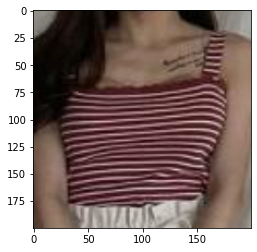

In [27]:
idx = np.random.randint(0, len(train_dataset))
print(idx)
plt.imshow(train_dataset[idx][0].permute(1,2,0))